In [1]:
# Data generation code adapted from https://m2lines.github.io/L96_demo/notebooks/L96-two-scale-description.html
import matplotlib.pyplot as plt
import numpy as np

from L96_model import L96_2t_xdot_ydot, integrate_L96_2t

In [2]:
def s(k, K):
    """A non-dimension coordinate from -1..+1 corresponding to k=0..K"""
    return 2 * (0.5 + k) / K - 1

# Generate data

In [3]:
K = 40  # Number of globa-scale variables X
J = 5  # Number of local-scale Y variables per single global-scale X variable
nt = 1000  # Number of time steps
si = 0.1  # Sampling time interval
dt = 0.005  # Time step
F = 8.0  # Forcing
h = 1.0  # Coupling coefficient
b = 10.0  # ratio of amplitudes
c = 10.0  # time-scale ratio

In [4]:
k = np.arange(K)  # For coordinate in plots
j = np.arange(J * K)  # For coordinate in plots

# Initial conditions
X_init = s(k, K) * (s(k, K) - 1) * (s(k, K) + 1)
Y_init = 0 * s(j, J * K) * (s(j, J * K) - 1) * (s(j, J * K) + 1)

# "Run" model
X, Y, t = integrate_L96_2t(X_init, Y_init, si, nt, F, h, b, c, dt=dt)

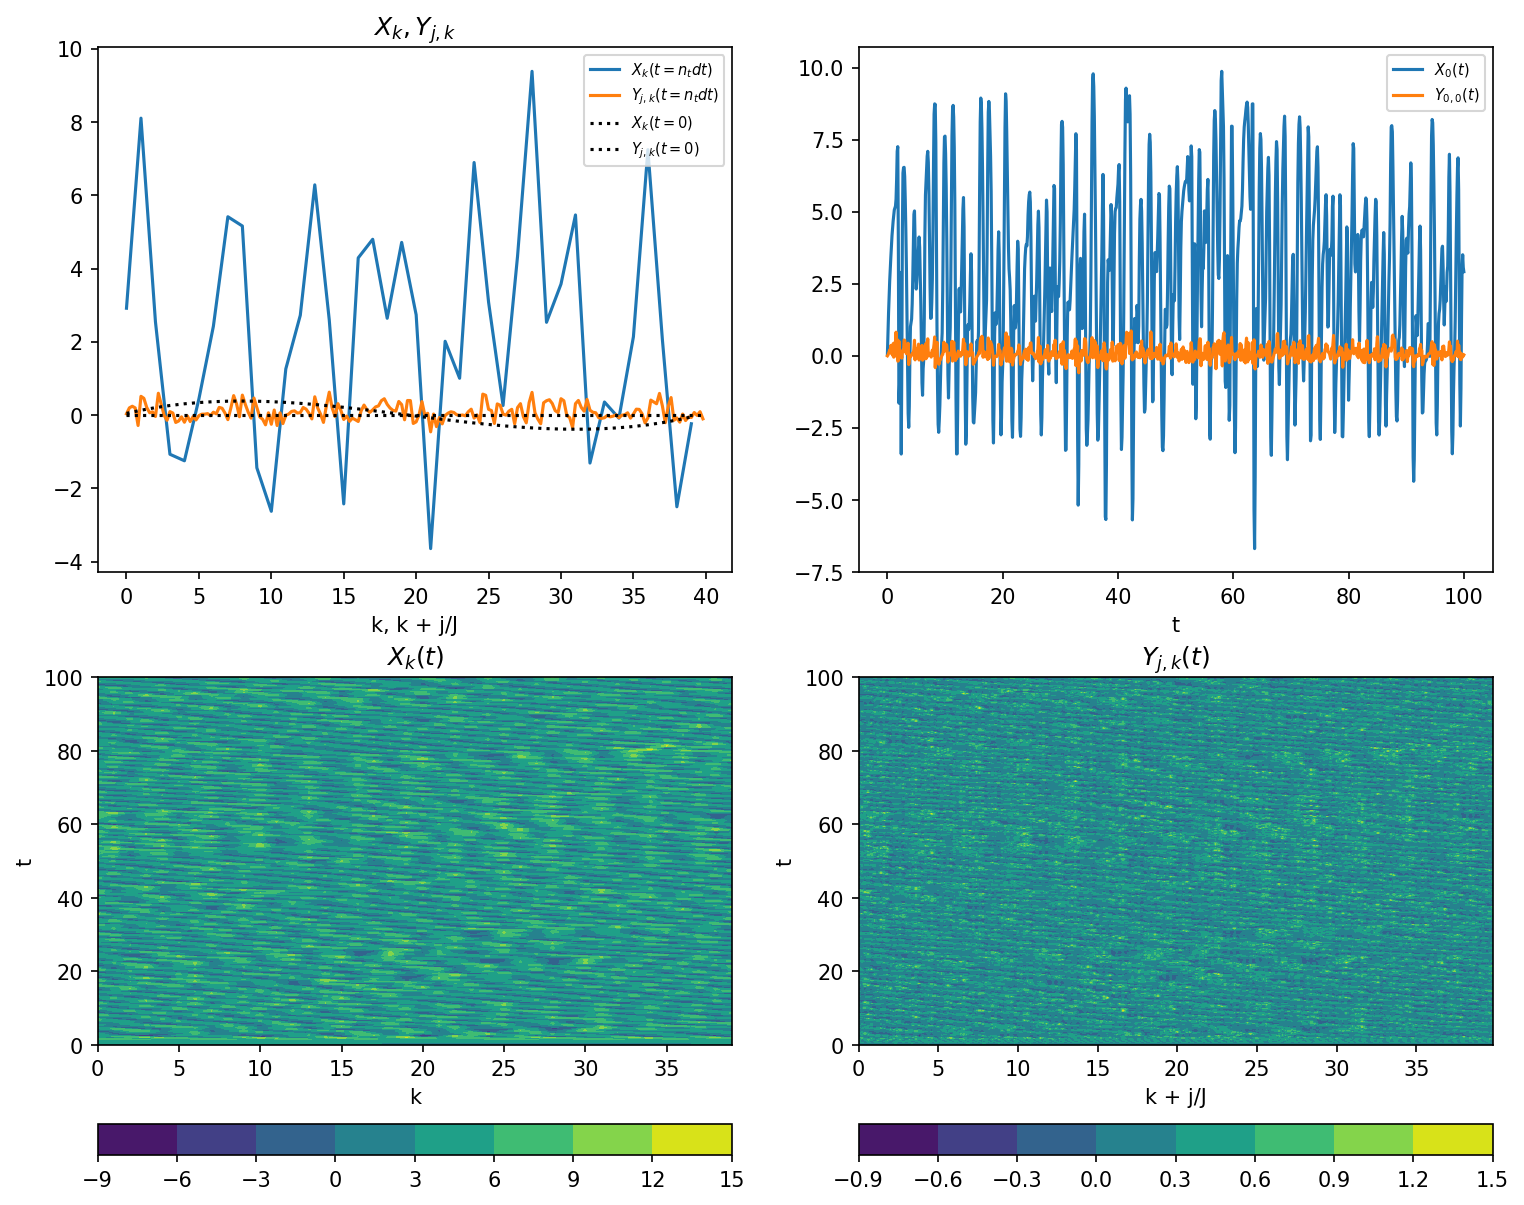

In [5]:
plt.figure(figsize=(12, 10), dpi=150)
plt.subplot(221)

# Snapshot of X[k]
plt.plot(k, X[-1], label="$X_k(t=n_t dt)$")
plt.plot(j / J, Y[-1], label="$Y_{j,k}(t=n_t dt)$")
plt.plot(k, X_init, "k:", label="$X_k(t=0)$")
plt.plot(j / J, Y_init, "k:", label="$Y_{j,k}(t=0)$")
plt.legend(fontsize=7)
plt.xlabel("k, k + j/J")
plt.title("$X_k, Y_{j,k}$")
plt.subplot(222)

# Sample time-series X[0](t), Y[0](t)
plt.plot(t, X[:, 0], label="$X_0(t)$")
plt.plot(t, Y[:, 0], label="$Y_{0,0}(t)$")
plt.legend(fontsize=7)
plt.xlabel("t")
plt.subplot(223)

# Full model history of X
plt.contourf(k, t, X)
plt.colorbar(orientation="horizontal")
plt.xlabel("k")
plt.ylabel("t")
plt.title("$X_k(t)$")
plt.subplot(224)

# Full model history of Y
plt.contourf(j / J, t, Y)
plt.colorbar(orientation="horizontal")
plt.xlabel("k + j/J")
plt.ylabel("t")
plt.title("$Y_{j,k}(t)$");

# Add noise

In [6]:
noise_scale = 0.001

X_noisy = X + np.random.normal(scale=noise_scale, size=X.shape)

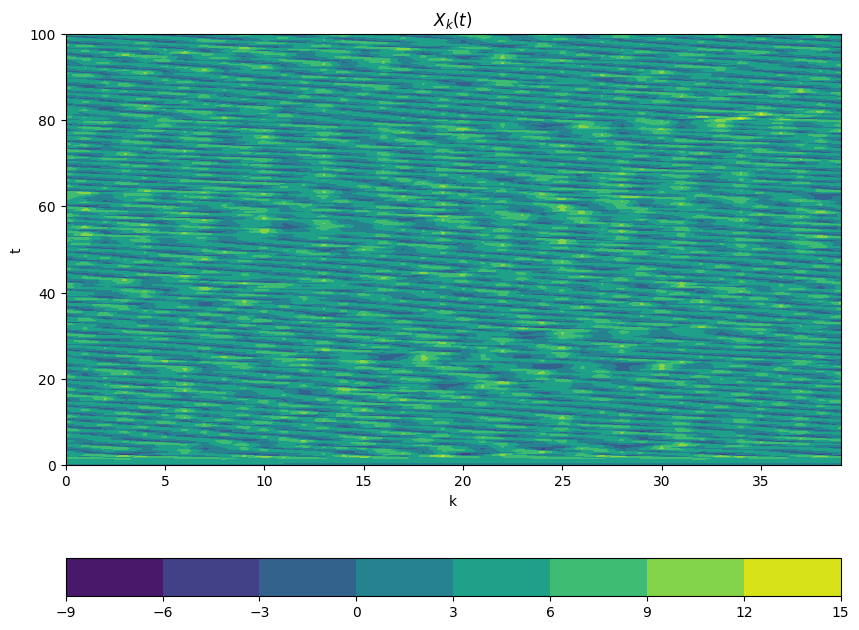

In [7]:
# Full model history of noisy X
plt.figure(figsize=(10,8))
plt.contourf(k, t, X_noisy)
plt.colorbar(orientation="horizontal")
plt.xlabel("k")
plt.ylabel("t")
plt.title("$X_k(t)$")
plt.show()

In [8]:
X.shape

(1001, 40)

# Running the ENKF

In [9]:
# slow forward model

from L96_model import integrate_L96_1t

In [10]:
X.shape

(1001, 40)

In [11]:
x, _ = integrate_L96_1t(X[0], F, si, nt)

In [12]:
x.shape

(1001, 40)

In [13]:
t[200]

20.0

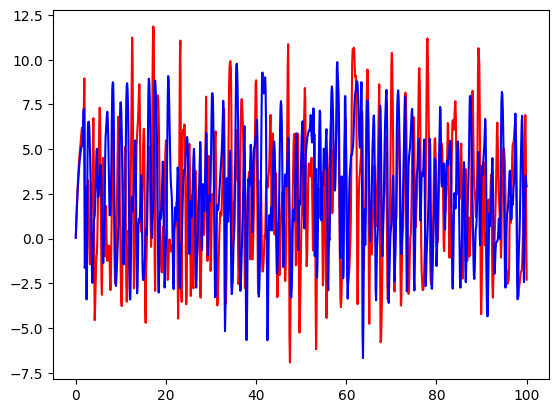

In [14]:
plt.plot(t, x[:, 0], color = 'red')
plt.plot(t, X[:, 0], color = 'blue')

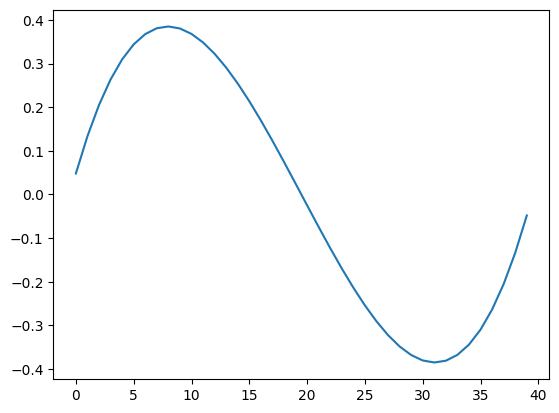

In [15]:
plt.plot(X[0, :])

In [16]:
N_particles = 50
particles = X[0] + np.random.normal(scale=1.0, size=(N_particles, K))

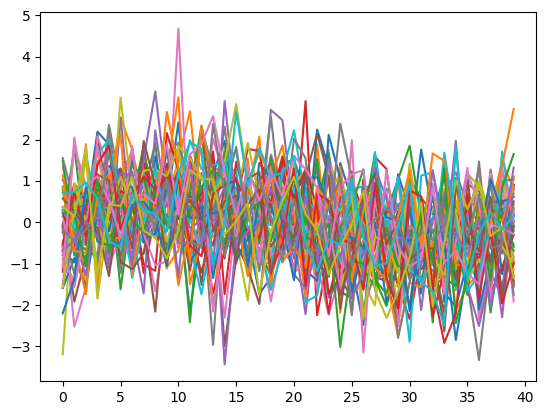

In [17]:
for i in range(N_particles):
    plt.plot(particles[i])

In [18]:
import scipy

In [19]:
noise_scale = 0.1

X_noisy = X + np.random.normal(scale=noise_scale, size=X.shape)

In [20]:
N_particles = 50
particles = np.random.normal(scale=10.0, size=(N_particles, K))

In [21]:
model_noise = 0.1

In [22]:
prediction = []
analysis = []
correction = []

particles = X[0] + np.random.normal(scale=1.0, size=(N_particles, K))

for i in range(nt):
    # propagate particles one step  forward
    for j in range(N_particles):
        particles[j] = integrate_L96_1t(particles[j], F, si, 1)[0][-1] + np.random.normal(scale=model_noise, size=K)

    prediction.append(np.copy(particles))

    # Compute the empirical covariance matrix
    cov = np.cov(particles.T)

    y = X_noisy[i+1]
    
    # Draw observational noise
    noise = np.random.normal(scale=noise_scale, size=particles.shape)

    increment = y - noise - particles
    #print(increment[2] - (y - (noise + particles)[2]))
    
    a = cov@scipy.linalg.solve(cov + (noise_scale**2)*np.eye(K), increment.T, assume_a='pos')
    correction.append(a.T)    

    #print(np.trace(cov@cov.T))

    particles = particles + a.T
    analysis.append(np.copy(particles))
    
    
analysis = np.array(analysis)
prediction = np.array(prediction)
correction = np.array(correction)

(0.0, 200.0)

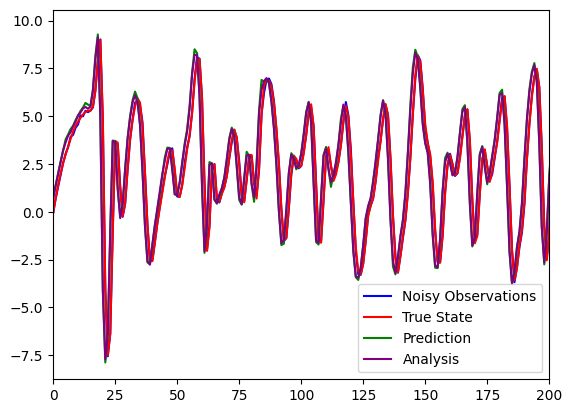

In [23]:
dim = -1
plt.plot(X_noisy[:, dim], label = 'Noisy Observations', color = 'blue')
plt.plot(X[:, dim], label = 'True State', color = 'red')
plt.plot(np.mean(prediction[:, :, dim], axis = 1), label = 'Prediction', color = 'green')
plt.plot(np.mean(analysis[:, :, dim], axis = 1), label = 'Analysis', color = 'purple')
plt.legend()
plt.xlim(0, 200)

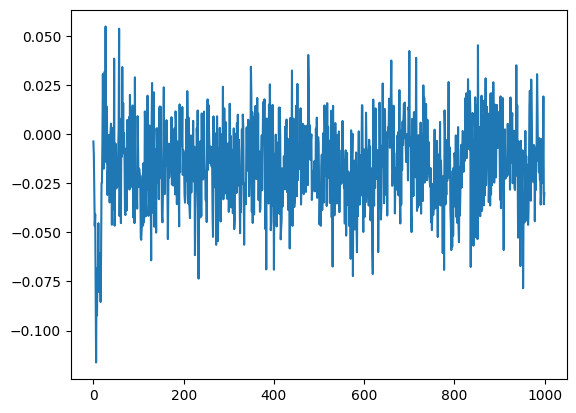

In [24]:
plt.plot(np.mean(correction[:, dim, :], axis = -1))

# Neural network training

In [25]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [26]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(K, 4*K),
            nn.ReLU(),
            nn.Linear(4*K, 4*K),
            nn.ReLU(),
            nn.Linear(4*K, K),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [27]:
inputs = torch.tensor(prediction, dtype=torch.float32)
outputs = torch.tensor(correction, dtype=torch.float32)

In [28]:
model = NeuralNetwork()
loss = nn.MSELoss()

# Initialize the optimizer to be adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Number of epochs
N = 200

loss_hist = []
# train the model
for epoch in range(N):
    for i in range(K):
        optimizer.zero_grad()
        outputs_pred = model(inputs[:, i, :])
        loss_value = loss(outputs_pred, outputs[:, i,:])
        loss_value.backward()
        optimizer.step()

        loss_hist.append(loss_value.item())
    print(f"Epoch {epoch}, Loss {loss_value}")

Epoch 0, Loss 0.023611202836036682
Epoch 1, Loss 0.022090237587690353
Epoch 2, Loss 0.02132505737245083
Epoch 3, Loss 0.020785639062523842
Epoch 4, Loss 0.02031194232404232
Epoch 5, Loss 0.019945884123444557
Epoch 6, Loss 0.01964597776532173
Epoch 7, Loss 0.01936396211385727
Epoch 8, Loss 0.019097190350294113
Epoch 9, Loss 0.018856558948755264
Epoch 10, Loss 0.018642129376530647
Epoch 11, Loss 0.01844516210258007
Epoch 12, Loss 0.018257474526762962
Epoch 13, Loss 0.018078124150633812
Epoch 14, Loss 0.017910558730363846
Epoch 15, Loss 0.017757520079612732
Epoch 16, Loss 0.01760665699839592
Epoch 17, Loss 0.01746818609535694
Epoch 18, Loss 0.017336688935756683
Epoch 19, Loss 0.01722019352018833
Epoch 20, Loss 0.01710239239037037
Epoch 21, Loss 0.01699226163327694
Epoch 22, Loss 0.016880229115486145
Epoch 23, Loss 0.01677631586790085
Epoch 24, Loss 0.01668020337820053
Epoch 25, Loss 0.01658504642546177
Epoch 26, Loss 0.016492927446961403
Epoch 27, Loss 0.01639755815267563
Epoch 28, Loss 0

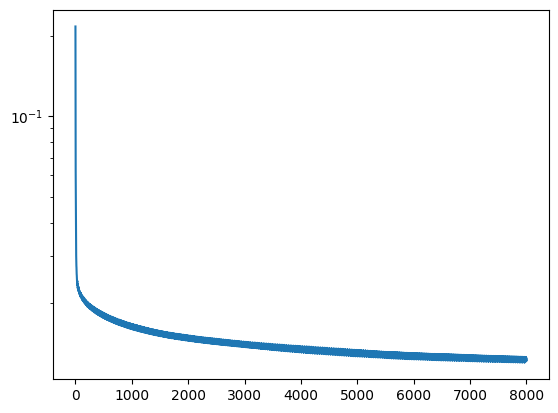

In [29]:
plt.plot(loss_hist)
plt.yscale('log')

# ENFK + NN

In [30]:
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=40, out_features=160, bias=True)
    (1): ReLU()
    (2): Linear(in_features=160, out_features=160, bias=True)
    (3): ReLU()
    (4): Linear(in_features=160, out_features=40, bias=True)
  )
)

In [31]:
N_particles = 50
particles = np.random.normal(scale=10.0, size=(N_particles, K))

In [32]:
#model(torch.tensor(particles, dtype=torch.float32)).detach().numpy()

In [33]:
prediction_nn = []
analysis_nn = []
correction_nn = []

particles = X[0] + np.random.normal(scale=1.0, size=(N_particles, K))

for i in range(nt):
    # propagate particles one step  forward
    for j in range(N_particles):
        particles[j] = integrate_L96_1t(particles[j], F, si, 1)[0][-1] + np.random.normal(scale=model_noise, size=K)

    particles = particles + model(torch.tensor(particles, dtype=torch.float32)).detach().numpy()    
    prediction_nn.append(np.copy(particles))

    # Compute the empirical covariance matrix
    cov = np.cov(particles.T)

    y = X_noisy[i+1]
    
    # Draw observational noise
    noise = np.random.normal(scale=noise_scale, size=particles.shape)

    increment = y - noise - particles
    #print(increment[2] - (y - (noise + particles)[2]))
    
    a = cov@scipy.linalg.solve(cov + (noise_scale**2)*np.eye(K), increment.T, assume_a='pos')
        
    particles = particles + a.T #+ model(torch.tensor(particles, dtype=torch.float32)).detach().numpy()
    analysis_nn.append(np.copy(particles))
    correction_nn.append(a.T)
    
    
analysis_nn = np.array(analysis_nn)
prediction_nn = np.array(prediction_nn)
correction_nn = np.array(correction_nn)

(0.0, 200.0)

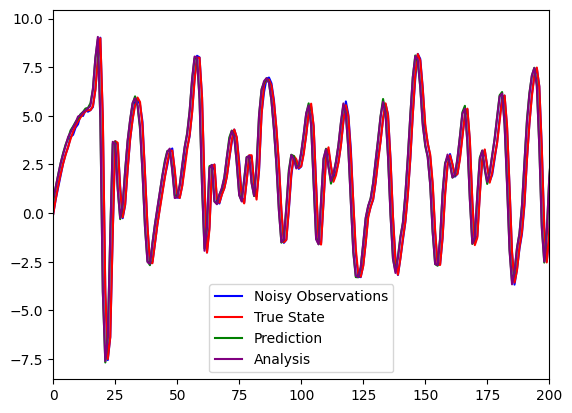

In [34]:
dim = -1
plt.plot(X_noisy[:, dim], label = 'Noisy Observations', color = 'blue')
plt.plot(X[:, dim], label = 'True State', color = 'red')
plt.plot(np.mean(prediction_nn[:, :, dim], axis = 1), label = 'Prediction', color = 'green')
plt.plot(np.mean(analysis_nn[:, :, dim], axis = 1), label = 'Analysis', color = 'purple')
plt.legend()
plt.xlim(0, 200)

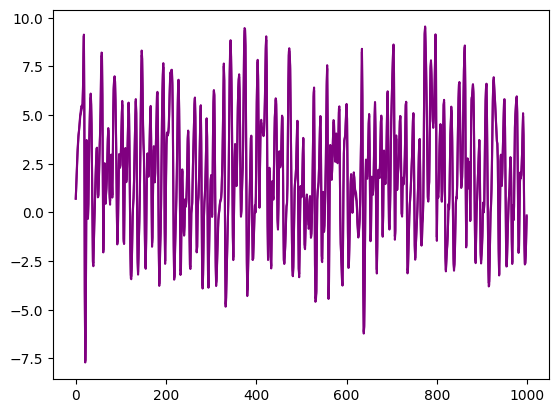

In [35]:
plt.plot(np.mean(analysis_nn[:, :, dim], axis = 1), label = 'Analysis', color = 'purple')
plt.plot(np.mean(analysis[:, :, dim], axis = 1), label = 'Analysis', color = 'purple')

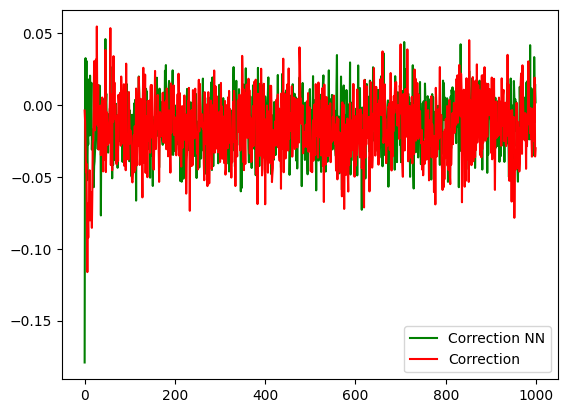

In [36]:
plt.plot(np.mean(correction_nn[:, dim, :], axis = -1), label = 'Correction NN', color = 'green')
plt.plot(np.mean(correction[:, dim, :], axis = -1), label = 'Correction', color = 'red')
plt.legend()

In [37]:
# Compute the RMSE between the true state and the analysis

np.mean((np.mean(analysis, axis = 1) - X_noisy[1:])**2)

0.013863465275156943

In [38]:
np.mean((np.mean(analysis_nn, axis = 1) - X_noisy[1:])**2)

0.0055168510113963315